# Aperture Photometry


In this short tutorial, we will:

1. Define a stamp geometry
2. Generate random simulations of the CMB
3. Initialize an NFW profile
4. Create a mock catalog of tSZ clusters with NFW profile at 150 GHz and 90 GHz
5. Plot aperture photometry flux for each frequency vs. true compton Y
6. Plot fitted Y vs true Y


In [19]:
from __future__ import print_function

# The main mapwork module
from enlib import enmap

import numpy as np
import matplotlib.pyplot as plt

# Tools for working with enmaps, i/o, catalogs and statistics
from orphics import maps,io,stats,cosmology,lensing


In [20]:
# Let's define a geometry centered on the equator by default

shape,wcs = maps.rect_geometry(width_arcmin=40.,px_res_arcmin=0.5)

# shape gives us the shape of the numpy matrix storing the map

print(shape)

# wcs is the World Coordinate System info that tells enlib what pixels correspond to what locations on the sky.
# Enlib essentially extends the numpy array to include wcs information

print(wcs)

(80, 80)
car:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[40.5,40.5]}


In [21]:
# What are the bounds of this geometry in arcmin?
bounds = enmap.box(shape,wcs)*60.*180./np.pi
print(bounds)

[[-20. -20.]
 [ 20.  20.]]


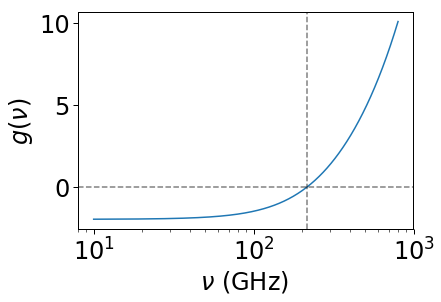

tSZ response at  90.0  GHz =  -1.5979481689284043
tSZ response at  150.0  GHz =  -0.9533273348182751
tSZ response at  217  GHz =  -0.007777597181995777


In [22]:
# Set up SZ frequency dependence
def gnu(nu_ghz,tcmb=2.7255):
    nu = 1e9*nu_ghz
    hplanck = 6.62607e-34
    kboltzmann = 1.38065e-23 
    x = hplanck*nu/kboltzmann/tcmb
    coth = np.cosh(x/2.)/np.sinh(x/2.)
    return x*coth-4.


null_nu = 217
nus = np.logspace(np.log10(10),np.log10(800),1000)
gnus = gnu(nus)
pl = io.Plotter(xlabel="$\\nu$ (GHz) ",ylabel="$g(\\nu)$",xscale='log')
pl.add(nus,gnus)
pl.hline()
pl.vline(x=null_nu)
pl.done()

test_nus = [90.,150.,null_nu]
for nu in test_nus:
    print("tSZ response at ", nu, " GHz = ", gnu(nu))


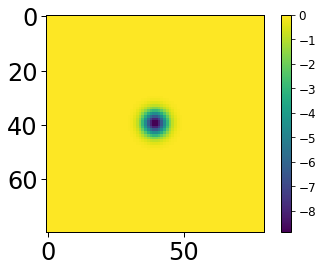

In [78]:
# Peak Compton-y values
logymin = -6
logymax = -4
Nclusters = 500
logys = np.random.uniform(logymin,logymax,Nclusters)
ys = 10**logys

def szmap(ymap,nu_ghz,tcmb=2.7255):
    return gnu(nu_ghz,tcmb)*ymap*1e6


# Example simulated SZ map
scale_arcmin = 1.5
scale = scale_arcmin*np.pi/180./60.
modrmap = enmap.modrmap(shape,wcs)
ytemplate = np.exp(-modrmap**2./2./scale**2.)

io.plot_img(szmap(ys[0]*ytemplate,90.))

In [79]:
# Set up simulations
cc = cosmology.Cosmology(lmax=6000,pickling=True,dimensionless=False)
theory = cc.theory
modlmap = enmap.modlmap(shape,wcs)
lmax = modlmap.max()
ells = np.arange(0,lmax,1)
cltt = theory.lCl('TT',ells)
ps = cltt.reshape((1,1,ells.size))
# CMB simulator
mgen = maps.MapGen(shape,wcs,ps)

# Noise in 150 simulator
noise_uk_arcmin_150 = 10.0
ps_noise_150 = ps*0.+(noise_uk_arcmin_150*np.pi/180./60.)**2.
ngen_150 = maps.MapGen(shape,wcs,ps_noise_150)

# Noise in 90 simulator
noise_uk_arcmin_90 = 20.0
ps_noise_90 = ps*0.+(noise_uk_arcmin_90*np.pi/180./60.)**2.
ngen_90 = maps.MapGen(shape,wcs,ps_noise_90)

# Beams
fwhm_150 = 1.4
fwhm_90 = (150./90.)*fwhm_150

kbeam_150 = maps.gauss_beam(modlmap,fwhm_150)
kbeam_90 = maps.gauss_beam(modlmap,fwhm_90)

Generating theory Cls...
Loaded cached Cls from  output/clsAll_low_acc_False_6000_20180304.pkl
Loaded cached Cls from  output/clphi_low_acc_False_6000_20180304.txt


In [106]:
st = stats.Stats()

# Choice of aperture photometry geometry
rad_150 = np.deg2rad(fwhm_150/60)
rad_90 = np.deg2rad(fwhm_90/60)
width_150 = np.deg2rad(fwhm_150/60)
width_90 = np.deg2rad(fwhm_90/60)

# Loop through clusters
for i,y in enumerate(ys):
    
    # Simulate the sky
    cmb = mgen.get_map()
    sz_150 = szmap(y*ytemplate,150.)
    sz_90 = szmap(y*ytemplate,90.) 

    # Simulate the instrument
    noise_150 = ngen_150.get_map()
    noise_90 = ngen_90.get_map()
    obs_150 = maps.filter_map(cmb+sz_150,kbeam_150) + noise_150
    obs_90 = maps.filter_map(cmb+sz_90,kbeam_90) + noise_90
    
    # Analysis starts here
    
    ap150 = maps.aperture_photometry(obs_150,rad_150,width_150,modrmap=modrmap)
    ap90 = maps.aperture_photometry(obs_90,rad_90,width_90,modrmap=modrmap)
    
    st.add_to_stats("results",np.array((y,ap90,ap150)))
    
    st.add_to_stack("obs150",obs_150)
    st.add_to_stack("obs90",obs_90)
    
    if (i+1)%200==0: print((i+1), " / ",len(ys)," done...")
st.get_stacks()
st.get_stats()

200  /  500  done...
400  /  500  done...


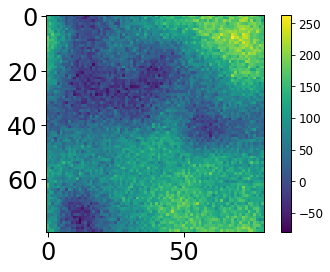

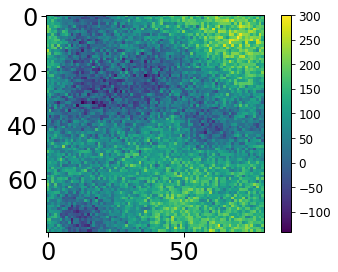

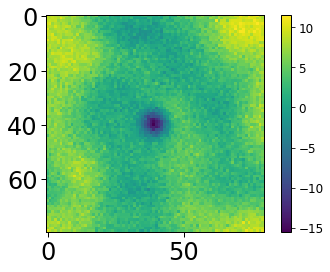

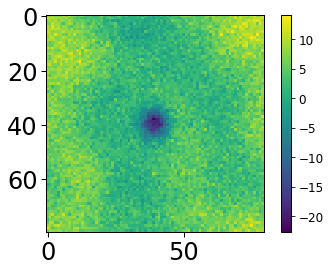

In [112]:
io.plot_img(obs_150)
io.plot_img(obs_90)
# Stacks
io.plot_img(st.stacks['obs150'])
io.plot_img(st.stacks['obs90'])

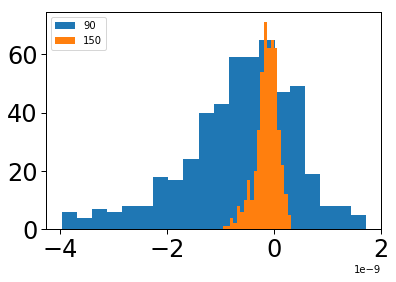

In [108]:
# Distribution of fluxes
yins = st.vectors['results'][:,0]
ap90s = st.vectors['results'][:,1]
ap150s = st.vectors['results'][:,2]
pl = io.Plotter()
pl._ax.hist(ap90s,bins=20,label="90")
pl._ax.hist(ap150s,bins=20,label="150")
pl.legend()
pl.done()

(array([200.,  67.,  52.,  26.,  23.,  14.,  15.,  13.,   7.,  16.,  10.,
          5.,   6.,   9.,   4.,   7.,   6.,   7.,   6.,   7.]),
 array([1.00654448e-06, 5.80813498e-06, 1.06097255e-05, 1.54113160e-05,
        2.02129065e-05, 2.50144970e-05, 2.98160875e-05, 3.46176780e-05,
        3.94192685e-05, 4.42208590e-05, 4.90224495e-05, 5.38240400e-05,
        5.86256305e-05, 6.34272210e-05, 6.82288115e-05, 7.30304020e-05,
        7.78319925e-05, 8.26335830e-05, 8.74351735e-05, 9.22367640e-05,
        9.70383545e-05]),
 <a list of 20 Patch objects>)

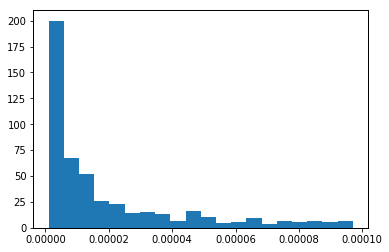

In [109]:
# True Y distribution
plt.clf()
plt.hist(yins,bins=20)


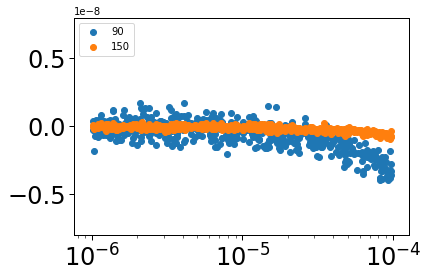

In [110]:
# Flux vs Y
pl = io.Plotter(xscale='log')
pl._ax.scatter(yins,ap90s,label="90")
pl._ax.scatter(yins,ap150s,label="150")
pl._ax.set_ylim(-8e-9,8e-9)
pl.legend()
pl.done()



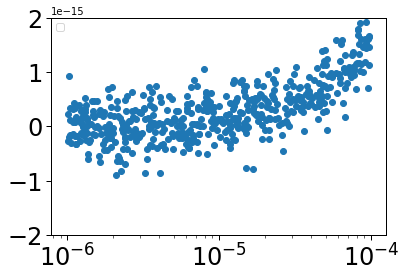

In [111]:
# Yfit vs Y

tcmb = 2.7255e6
a150 = tcmb*gnu(150)
a90 = tcmb*gnu(90)

yfit = (ap150s-ap90s)/(a150-a90)


pl = io.Plotter(xscale='log')
pl._ax.scatter(yins,yfit)
pl._ax.set_ylim(-2e-15,2e-15)
pl.legend()
pl.done()


